In [121]:
import pandas as pd
import ast

# Function to get crypto price
def get_crypto_prices(crypto = "BTC"):
    columns = {"ticker":[], "date":[], "open":[], "high":[], "low":[], "close":[]}
    df = pd.DataFrame(data=columns)
    try:
        df = pd.read_csv(f'../crypto_prices/{crypto}.csv')
    except FileNotFoundError as e:
        print(f"Could not find file {crypto}") 
    return df

# Function to get crypto news
def get_crypto_news():
    df = pd.read_csv(f'../crypto_news/cryptonews.csv')
    df['date'] = df["date"].str[:10].str.strip()
    df['date'] = pd.to_datetime(df['date'])
    # df.set_index("date", inplace=True)
    return df

a = get_crypto_news()
b = get_crypto_prices()

In [122]:
import ta
from sklearn.preprocessing import MinMaxScaler
import ta.volatility


# get crypto prices
df = get_crypto_prices("BTC")

# Adds derived fields using Technical Analylsis Library
df['MA_10'] = df['close'].rolling(window=10).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()
df['RSI'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['MACD'] = ta.trend.MACD(df['close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['close']).macd_signal()
df['ADX_Indicator'] = ta.trend.ADXIndicator(df['high'],df['low'],df['close'],14).adx()
indicator_bb = ta.volatility.BollingerBands(close=df["close"], window=20, window_dev=2)
# Add Bollinger Band high indicator
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# 2. Calculate 3d, 7d, 1M, 3M and 6M Rolling low and highs
windows = {
        '3D': 3,
        '7D': 7,
        '1M': 30,
        '3M': 90,
        '6M': 180
}
for key, window in windows.items():
        df[f'Roll_Low_{key}'] = df['close'].rolling(window=window).min()
        df[f'Roll_High_{key}'] = df['close'].rolling(window=window).max()

df['3dUpTrend'] = (df['close'] >= df['Roll_High_3D']).astype(int)
df['6mUpTrend'] = (df['close'] >= df['Roll_High_6M']).astype(int) 

# 3. Handle missing values
df.ffill(inplace=True)
df.bfill(inplace=True)

# Set the 'date' column as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index("date", inplace=True)

# 4. Normalise data
# Select features for normalization
# features = ['close','bb_bbhi','bb_bbli','RSI', 'MACD_signal',"ADX_Indicator", '3dUpTrend', '6mUpTrend']
features = ['close','RSI', 'MACD_signal',"ADX_Indicator", '3dUpTrend', '6mUpTrend']

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

# Convert to DataFrame
price_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
price_df.head()


# Get news sentiment data for BTC
news_df = get_crypto_news()
# Only bitcoin news
news_df = news_df[news_df["subject"] == "bitcoin"] 
# get sentiment dic
news_df["sentiment_dic"] = news_df['sentiment'].apply(ast.literal_eval)
news_df["sentiment_dic"]
news_df[['class','polarity','subjectivity']] = news_df['sentiment_dic'].apply(pd.Series)
news_df.drop(columns=["sentiment_dic", "sentiment", "source", "text", "url", "title", "subject"],inplace=True)

# merge price and data
df = pd.merge(price_df, news_df, on="date", how="left")
df['class'] = df['class'].fillna("neutral")
df['polarity'] = df['polarity'].fillna(0)
df['subjectivity'] = df['subjectivity'].fillna(0)
class_mapping = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}
df['class'] = df['class'].map(class_mapping)

# Del date as its not needed for further analysis - only for plotting
df_date = pd.DataFrame(df['date'])
del df['date']

In [124]:
# Check table
df.head()
df.size

128970

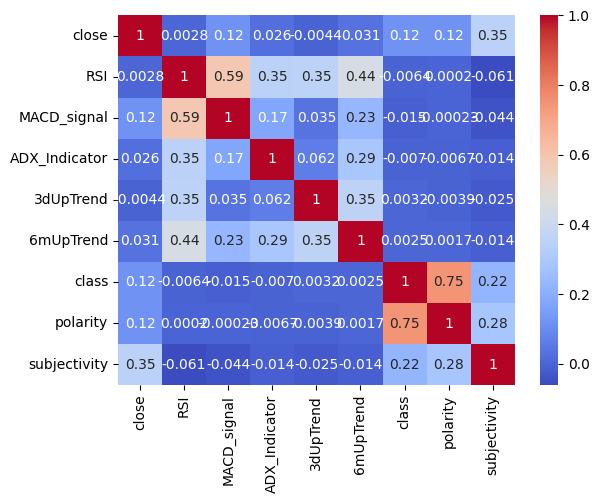

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

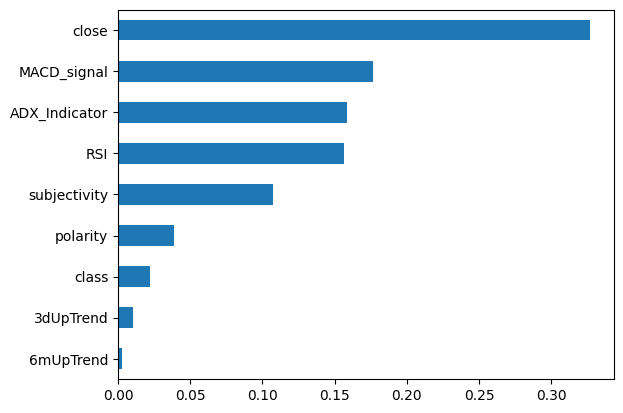

In [104]:
# Feature importance using Random Forest
from sklearn.ensemble import RandomForestClassifier
X = df.iloc[:-1,:]  # Assuming 'Close' is the target
y = (df['close'].shift(-1) > df['close']).astype(int)  # Binary classification: 1 if price increases, 0 otherwise
model = RandomForestClassifier()
model.fit(X, y[:-1])

importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
feature_importance.sort_values().plot(kind='barh')
plt.show()


In [105]:
# # Select features with importance greater than a threshold
# threshold = 0.05
# important_features = feature_importance[feature_importance > threshold].index

# # Create a new DataFrame with only important features
# X_important = X[important_features]

# # Re-train the model with important features only
# model.fit(X_important, y)

# # Evaluate the model
# y_pred = model.predict(X_important)
# from sklearn.metrics import classification_report
# print(classification_report(y, y_pred))

In [106]:
# Creating Sequences for LSTM
import numpy as np
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 60  # Example window size
X, y = create_sequences(df.values, window_size)
y = (df['close'].shift(-1) > df['close']).astype(int)[window_size:]  # Target variable

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model Creation and Training

# Split the data into training and testing sets
split = int(0.8 * len(X))  # 80-20 split for training and testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/4
357/357 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7899 - loss: 0.4002 - val_accuracy: 0.9306 - val_loss: 0.2040
Epoch 2/4
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8059 - loss: 0.3494 - val_accuracy: 0.9289 - val_loss: 0.2130
Epoch 3/4
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8098 - loss: 0.3532 - val_accuracy: 0.9341 - val_loss: 0.2027
Epoch 4/4
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8050 - loss: 0.3545 - val_accuracy: 0.9296 - val_loss: 0.2144


In [112]:
history.history["accuracy"]
history.history["loss"]
history.history["val_accuracy"]
history.history["val_loss"]

[0.20401498675346375,
 0.21298040449619293,
 0.20271950960159302,
 0.21441209316253662]

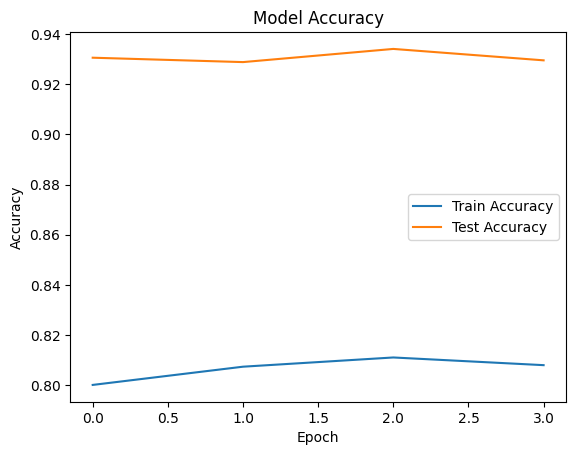

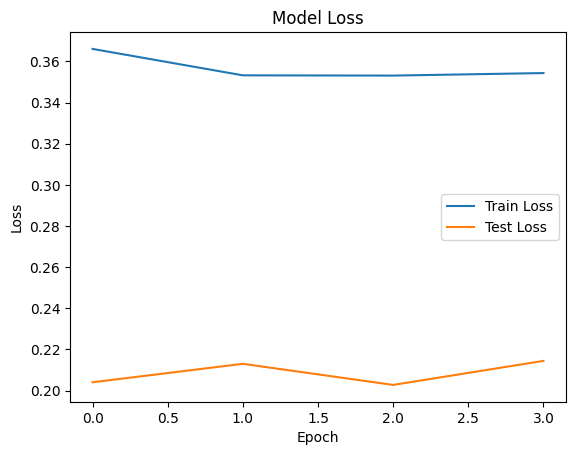

In [113]:
# Model Evaluation and Prediction
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [114]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Convert predictions and true values back to their original scales if needed
# For example, if y_test was scaled, apply inverse scaling

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2649
           1       0.55      0.10      0.17       205

    accuracy                           0.93      2854
   macro avg       0.74      0.55      0.57      2854
weighted avg       0.91      0.93      0.91      2854



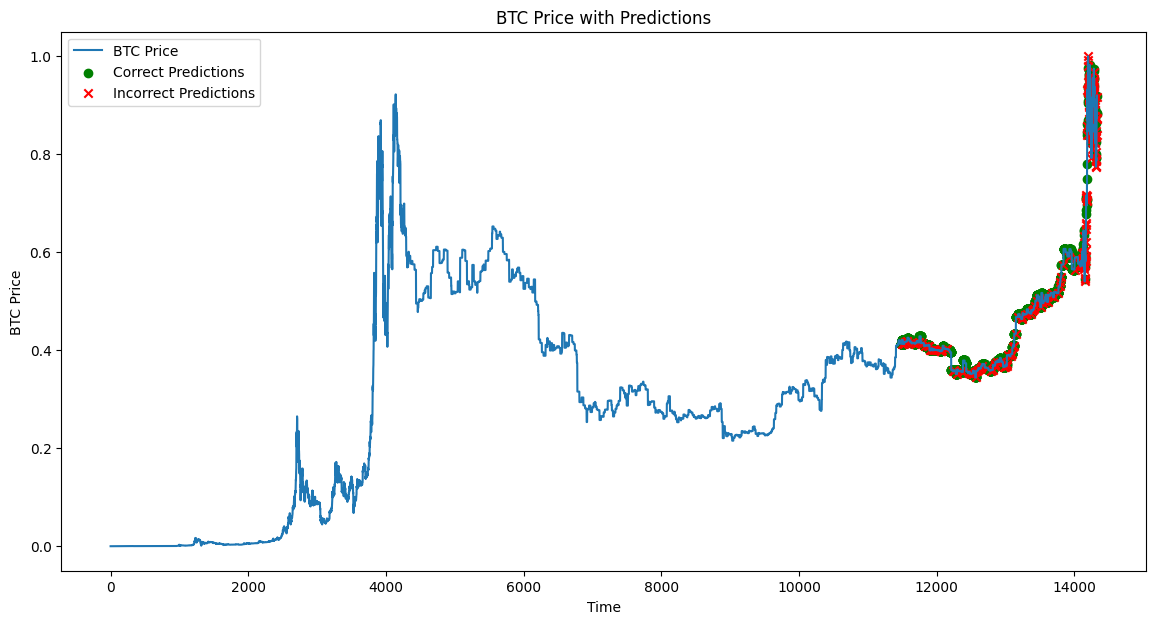

In [115]:
# Convert predictions and actual values to DataFrame
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})

# Plot BTC price
plt.figure(figsize=(14,7))
plt.plot(df['close'],label='BTC Price')
# plt.plot(df_date['date'],df['close'],label='BTC Price')

# # Mark correct predictions
correct_predictions = results[results['Actual'] == results['Predicted']]
plt.scatter(correct_predictions.index, df.loc[correct_predictions.index]['close'], color='green', label='Correct Predictions', marker='o')

# # # Mark incorrect predictions
incorrect_predictions = results[results['Actual'] != results['Predicted']]
plt.scatter(incorrect_predictions.index, df.iloc[incorrect_predictions.index]['close'], color='red', label='Incorrect Predictions', marker='x')

plt.title('BTC Price with Predictions')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()


In [116]:
print("Total number of predictions: ",results.size)
print("Total number of correct predictions: ",correct_predictions.size)
print("Total number of incorrect predictions: ",incorrect_predictions.size)
print("successful prediction rate: ", correct_predictions.size/results.size)

Total number of predictions:  5708
Total number of correct predictions:  5306
Total number of incorrect predictions:  402
successful prediction rate:  0.9295725297827611
